<a href="https://colab.research.google.com/github/sranga/UMass-AIML-Bootcamp/blob/main/Fake_News_Detection_Reproduction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# ============================================
# Fast Tiny-BERT Fake News Detection
# Capstone Step 4 – Reproduction Experiments
# ============================================

# Upgrade and install dependencies
!pip install --upgrade -q transformers datasets torch evaluate scikit-learn matplotlib

# Load Dataset
import pandas as pd

df = pd.read_csv('fake_and_real_news.csv')
print("Initial dataset shape:", df.shape)

# Subsample for fast execution
train_df = df.sample(2000, random_state=42)
test_df = df.drop(train_df.index).sample(500, random_state=42)
print(f"Train: {len(train_df)}, Test: {len(test_df)}")

# Tokenization
from datasets import Dataset
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

def tokenize_fn(batch):
    return tokenizer(batch['text'], truncation=True, padding='max_length', max_length=64)

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)

train_dataset = train_dataset.map(tokenize_fn, batched=True)
test_dataset = test_dataset.map(tokenize_fn, batched=True)

train_dataset = train_dataset.remove_columns(['text'])
test_dataset = test_dataset.remove_columns(['text'])
train_dataset.set_format('torch')
test_dataset.set_format('torch')

# Model Training
from transformers import AutoModelForSequenceClassification, Trainer, TrainingArguments
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

model = AutoModelForSequenceClassification.from_pretrained("prajjwal1/bert-tiny", num_labels=2)

training_args = TrainingArguments(
    output_dir='./results',
    eval_strategy='epoch',
    save_strategy='epoch',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=1,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=50,
    fp16=True
)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return {
        'accuracy': accuracy_score(labels, preds),
        'precision': precision_score(labels, preds),
        'recall': recall_score(labels, preds),
        'f1': f1_score(labels, preds),
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

# Evaluation & Confusion Matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

preds = trainer.predict(test_dataset)
y_true = test_dataset['label']
y_pred = np.argmax(preds.predictions, axis=1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['FAKE','REAL'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# Save Model & Results
model.save_pretrained('./fake_news_model_tiny')
tokenizer.save_pretrained('./fake_news_model_tiny')

results = trainer.evaluate()
with open('results_summary_tiny.txt','w') as f:
    f.write(str(results))

print("Fast Tiny-BERT reproduction complete. Model, tokenizer, and results saved.")


Initial dataset shape: (44898, 5)
Missing values per column:
 title      0
text       0
subject    0
date       0
label      0
dtype: int64

Label distribution:
 label
0    23481
1    21417
Name: count, dtype: int64

After dropping missing values: (44898, 5)

After removing outliers: (43710, 7)

After removing duplicates: (38299, 7)


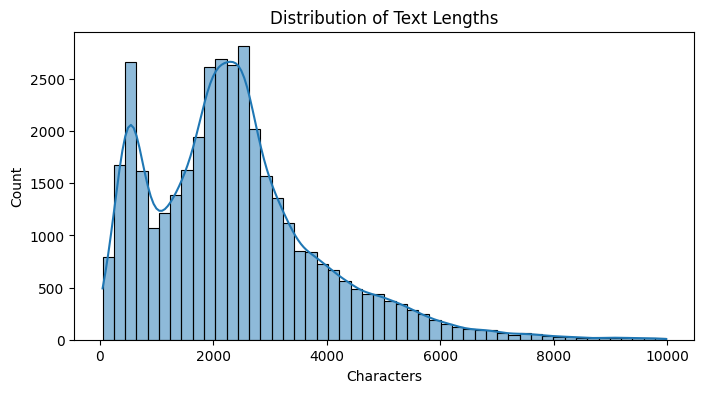

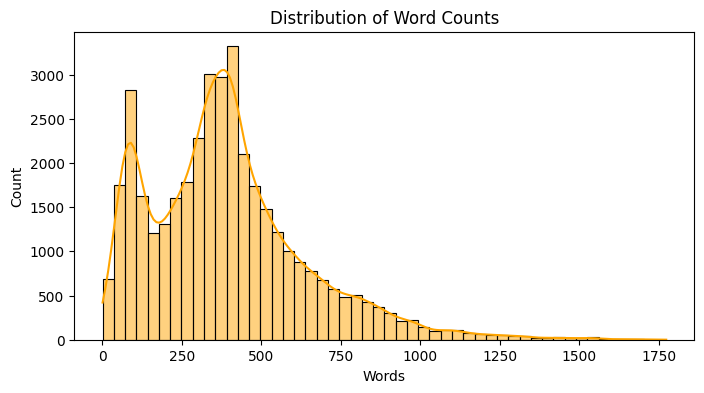

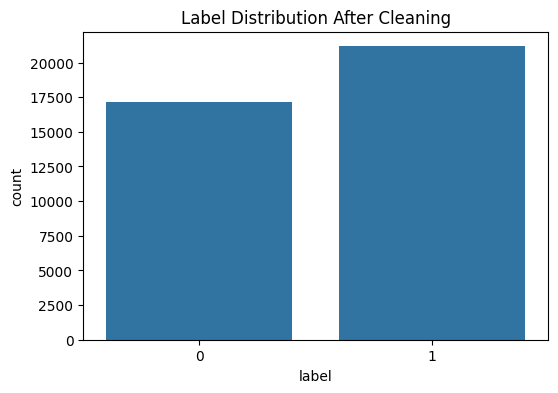

✅ Cleaned dataset saved as fake_and_real_news_cleaned.csv
Final dataset shape: (38299, 7)
Columns: Index(['title', 'text', 'subject', 'date', 'label', 'text_length',
       'word_count'],
      dtype='object')


In [1]:
# ============================================
# Fake News Data Wrangling
# Capstone Step 5 – Data Wrangling
# ============================================

# Install dependencies
!pip install -q pandas matplotlib seaborn

# Load Dataset
import pandas as pd

df = pd.read_csv('fake_and_real_news.csv')
print("Initial dataset shape:", df.shape)
df.head(3)

# Basic Exploration
print("Missing values per column:\n", df.isnull().sum())
print("\nLabel distribution:\n", df['label'].value_counts())

# Handle Missing Values
# Drop rows with missing text or label
df = df.dropna(subset=['text','label'])
print("\nAfter dropping missing values:", df.shape)

# Handle Outliers
# Add text length
df['text_length'] = df['text'].apply(len)
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Remove extremely short (<50 chars) or extremely long (>10000 chars) articles
df = df[(df['text_length'] >= 50) & (df['text_length'] <= 10000)]
print("\nAfter removing outliers:", df.shape)

# Remove Duplicates
df = df.drop_duplicates(subset=['text'])
print("\nAfter removing duplicates:", df.shape)

# Visualizations
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribution of Text Lengths")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(8,4))
sns.histplot(df['word_count'], bins=50, kde=True, color='orange')
plt.title("Distribution of Word Counts")
plt.xlabel("Words")
plt.ylabel("Count")
plt.show()

plt.figure(figsize=(6,4))
sns.countplot(x='label', data=df)
plt.title("Label Distribution After Cleaning")
plt.show()

# Save Cleaned Dataset
df.to_csv("fake_and_real_news_cleaned.csv", index=False)
print("Cleaned dataset saved as fake_and_real_news_cleaned.csv")

# Summary
print("Final dataset shape:", df.shape)
print("Columns:", df.columns)
